# Packages and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
def adjust_data_types(df):
    for col in df.columns:
        unique_vals = df[col].unique()
        if df[col].dtypes == 'object':
            None
#         elif (set(unique_vals) == {0, 1}) or col == 'userId':
#             df[col] = df[col].astype('int64')
#         else:
#             df[col] = df[col].astype('float64')
        elif (set(unique_vals) != {0, 1}):
            df[col] = df[col].astype('float64')
        else:
            df[col] = df[col].astype('int64')
    return df

In [3]:
# ho_t02['userId'] = ho_t02['userId'].astype('str')
# ho_t02 = adjust_data_types(ho_t02)
# ho_t02.info()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.feature_selection import RFE, RFECV, VarianceThreshold

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, permutation_test_score
from sklearn.base import clone


from imblearn.metrics import geometric_mean_score
import shap

from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline
# from sklearn.pipeline import Pipeline

import dice_ml

from catboost import CatBoostClassifier

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.


In [5]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

specificity_scorer = make_scorer(specificity_score)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    npv = tn / (tn + fn)
    return npv

npv_scorer = make_scorer(npv_score)

g_mean_scorer = make_scorer(geometric_mean_score)


skf = StratifiedKFold(10, shuffle=True, random_state=0)

# def get_cat_cols(df):
#     one_hot_encoded_columns = []

#     for idx, column in enumerate(df.columns):
#         if df[column].nunique() == 2 and set(df[column].unique()) == {0, 1}:
#             one_hot_encoded_columns.append(idx)

#     return one_hot_encoded_columns

def get_cat_cols(df):
    return df.select_dtypes(include=['object']).columns.tolist()

# get_cat_cols(ho_t02)
# cat_cols = get_cat_cols(ho_t02)
# num_cols = [col for col in ho_t02.columns if col not in cat_cols]
# cat_cols, num_cols

In [6]:
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek


from sklearn.base import BaseEstimator, TransformerMixin

class DropCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Assuming X is a DataFrame
        non_categorical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
        return X[non_categorical_cols]


def knn_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', KNeighborsClassifier())
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
#             SMOTEENN(random_state=random_state),
#             SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
#             TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)
        ],
        'classifier__n_neighbors': list(range(1, 16)),
        'classifier__metric': ['euclidean', 'cosine', 'hamming', 'braycurtis',
                               'chebyshev', 'canberra', 'cityblock', 'sqeuclidean'
                              ]
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def svm_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', SVC(random_state=random_state, max_iter=1000,
                           verbose=True))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#         ],
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
        'classifier__C': list(np.logspace(-6, 6, num=13)),
        'classifier__probability': [True, False],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def logreg_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
#         ('drop_categorical', None),
#         ('encoder', None),
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', LogisticRegression(random_state=random_state, max_iter=1000))
    ])

    param_grid = {
#         'drop_categorical': [None, DropCategoricalFeatures()]
#         'encoder': [None, OneHotEncoder(sparse_output=False)],
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
        'classifier__C': list(np.logspace(-6, 6, num=13)),
        'classifier__penalty': ['l2', None],
        'classifier__solver': ['liblinear', 'lbfgs', 'newton-cholesky']
#         'classifier__penalty': ['l1', l2', 'elasticnet', 'None']
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df



def dt_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    cat_cols = get_cat_cols(X_train)
    num_cols = [col for col in X_train.columns if col not in cat_cols]


    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(), 
#             RobustScaler(),
#             MinMaxScaler()
#         ],
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
            SMOTEENN(random_state=random_state),
            SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
            TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)
        ],
#         'classifier__max_depth': [3],
# #         'classifier__min_samples_split': [1],
#         'classifier__min_samples_leaf': [1],
#         'classifier__max_depth': [2, 5],
#         'classifier__min_samples_split': [3],
#         'classifier__min_samples_leaf': [3],
# #         'classifier__max_features': ['auto', 'sqrt', 'log2', None],
#         'classifier__criterion': ["entropy", "log_loss"]
#         'classifier__max_depth': [2, 3],
#         'classifier__min_samples_split': [1],
#         'classifier__min_samples_leaf': [2, 3],
        'classifier__max_depth': [2, 3, 5],
        'classifier__min_samples_split': [2, 3],
        'classifier__min_samples_leaf': [1, 2, 3],
        'classifier__max_features': ['auto', 'sqrt', 'log2', None],
        'classifier__criterion': ["gini", "entropy", "log_loss"]
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
#                                cv=10, scoring=scorer,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

from sklearn.decomposition import TruncatedSVD

def rf_class2(df, scorer, label_col, scaler, random_state=0):
#     df_majority = df[df.home_ownership_class == 0]
#     df_minority = df[df.home_ownership_class == 1]

# #     display(df_majority)
# #     display(df_minority)
# #     print(len(df_majority), len(df_minority))
#     # Randomly downsample majority class
#     df_majority_downsampled = df_majority.sample(frac=0.2,
#                                                  random_state=random_state)
#     df = pd.concat([df_majority_downsampled, df_minority], axis=0)

    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)

#     n_components = X_scaled.shape[1]  # Maximum number of components
#     svd = TruncatedSVD(n_components=n_components)
#     X_svd = svd.fit_transform(X_scaled)

#     # Step 3: Find number of components that explain at least 90% variance
#     cum_variance = np.cumsum(svd.explained_variance_ratio_)
#     num_components = np.argmax(cum_variance >= 0.90) + 1  # +1 because Python indexing starts from 0
#     X_selected = X_svd[:, :num_components]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

#     X_resampled, y_resampled = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
#     class_counts_original = np.bincount(y_train.astype(int))
#     class_counts_resampled = np.bincount(y_resampled.astype(int))

    # Assuming 0 is the majority class, calculate its upweight factor
#     majority_class_original = class_counts_original[0]
#     majority_class_resampled = class_counts_resampled[0]
#     upweight_factor = majority_class_original / majority_class_resampled

#     minority_class_original = class_counts_original[1]
#     minority_class_resampled = class_counts_resampled[1]
#     downweight_factor = minority_class_original / minority_class_resampled

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
#             SMOTEENN(random_state=random_state),
#             SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
#             TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)
        ],
        'classifier__n_estimators': [200, 300],
        'classifier__max_depth': [2, 3],
        'classifier__min_samples_split': [2, 3],
        'classifier__min_samples_leaf': [2, 3],
        'classifier__oob_score': [True, False],
        'classifier__criterion': ["gini", "entropy", "log_loss"]

#         'classifier__n_estimators': [200, 250],
#         'classifier__max_depth': [2, 3],
#         'classifier__min_samples_split': [3, 4],
#         'classifier__min_samples_leaf': [3, 4],
#         'classifier__oob_score': [True, False],
#         'classifier__criterion': ["gini", "entropy", "log_loss"]
    }
#         'classifier__n_estimators': [200, 250, 300],
# #         'classifier__max_depth': [2, 3, 4],
#         'classifier__max_depth': [2],
#         'classifier__class_weight': [{0: 263/807, 1:1}],
#         'classifier__oob_score': [True],
# #         'classifier__class_weight': [{0: 1, 1:807/263}],
#         'classifier__min_samples_split': [3, 4],
#         'classifier__min_samples_leaf': [3, 4],
#         'classifier__criterion': ["gini", "entropy", "log_loss"]
#     }
    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
#                                cv=10, scoring=scorer,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def gbm_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', GradientBoostingClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
        'resampling': [
            SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
#         'classifier__n_estimators': [200],
#         'classifier__max_depth': [None],
#         'classifier__min_samples_leaf': [3],
#         'classifier__min_samples_split': [5],
#         'classifier__learning_rate': [0.1]
        'classifier__n_estimators': [200, 250],
        'classifier__max_depth': [2, 3],
        'classifier__min_samples_leaf': [2, 3],
        'classifier__min_samples_split': [2, 3],
        'classifier__learning_rate': [0.1]
    }
#         'loss': ['log_loss', 'deviance', 'exponential']
#         'min_samples_leaf': [1, 2, 3],
#         'min_samples_split': [2, 3, 5],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def lgbm_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, len(explained_var_ratio)+1), cumulative_explained_var, marker='o', linestyle='--')
#     plt.title('Cumulative Explained Variance Plot')
#     plt.xlabel('Number of Components')
#     plt.ylabel('Cumulative Explained Variance')
#     plt.grid(True)
#     plt.show()

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', LGBMClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
#         'classifier__n_estimators': [400, 450],
#         'classifier__learning_rate': [0.01],
#         'classifier__num_leaves': [20, 25],
#         'classifier__min_child_samples': [40, 45],
#         'classifier__class_weight': [{0: 263/807, 1:1}, {0: 1, 1:807/263}],
#         'classifier__class_weight': [{0: 1, 1:807/263}],
#         'classifier__max_depth': [2, 3],
#         'classifier__boosting_type': ['gbdt', 'dart', 'goss']

        'classifier__n_estimators': [200, 300, 400],
        'classifier__learning_rate': [0.1, 0.01],
#         'classifier__num_leaves': [20, 25],
#         'classifier__min_child_samples': [40, 45],
#         'classifier__class_weight': [{0: 263/807, 1:1}, {0: 1, 1:807/263}],
#         'classifier__class_weight': [{0: 1, 1:807/263}],
        'classifier__max_depth': [2, 3],
        'classifier__boosting_type': ['gbdt', 'dart', 'goss']
    }
#         'classifier__num_leaves': [20, 31, 40],
#         'classifier__min_child_samples': [10, 20, 30],
#         'classifier__max_depth': [-1, 5, 10],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def xgb_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', XGBClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
# #         'classifier__n_estimators': [200, 250],
#         'classifier__learning_rate': [2, 3],
# #         'classifier__max_depth': [2, 3],
#         'classifier__max_leaves': [5],
#         'classifier__grow_policy': ['depthwise', 'lossguide']
        'classifier__n_estimators': [200, 250],
        'classifier__learning_rate': [0.01, 0.1, 1],
        'classifier__max_depth': [None, 2, 3],
        'classifier__max_leaves': [10, 20, 30],
        'classifier__grow_policy': ['depthwise', 'lossguide']
    }
#         'classifier__max_depth': [None, 5, 10],
#         'classifier__max_leaves': [0, 10, 20],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def adaboost_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    cat_cols = get_cat_cols(X_train)
    num_cols = [col for col in X_train.columns if col not in cat_cols]

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', AdaBoostClassifier(
            random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
#             SMOTEENN(random_state=random_state),
#             SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
#             TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)],
        'classifier__n_estimators': [200, 300],
        'classifier__estimator': [DecisionTreeClassifier(
            random_state=random_state,
#             criterion='entropy', max_depth=3,
#             min_samples_leaf=2, min_samples_split=2
        ),
                                  RandomForestClassifier(
            random_state=random_state,
#             max_depth=3, min_samples_leaf=2,
#             min_samples_split=2, n_estimators=250,
#             oob_score=True
                                                        )],
#         'classifier__learning_rate': [0.01, 0.1, 1],
        'classifier__algorithm': ['SAMME', 'SAMME.R']
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

from sklearn.linear_model import RidgeClassifier

def ridge_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    cat_cols = get_cat_cols(X_train)
    num_cols = [col for col in X_train.columns if col not in cat_cols]
    
    cat_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    num_transformer = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.15))
    ])
    
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ],
        remainder='passthrough'
    )

    preprocessor_num = ColumnTransformer(
        transformers = [
            ('num', num_transformer, num_cols)
        ],
        remainder='drop'
    )

    preprocessor_drop_cat = ColumnTransformer(
        transformers = [
            ('num', 'passthrough', num_cols)
        ],
        remainder='drop'
    )

    pipeline = Pipeline([
#         ('preprocessor', None),
        ('preprocessor', preprocessor_drop_cat),
        ('scaler', scaler),
        ('resampling', None),
        ('var_threshold', VarianceThreshold(threshold=0.15)),
        ('classifier', RidgeClassifier(max_iter=1000, random_state=random_state))
    ])

    param_grid = {
#         'preprocessor': [
#             preprocessor_drop_cat,
#             preprocessor,
#             preprocessor_num            
#         ],
        'resampling': [ADASYN(random_state=random_state),
                       SMOTEENN(random_state=random_state),
                       SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
                       TomekLinks(),
                       RandomUnderSampler(random_state=random_state)],
        'classifier__alpha': [0.01, 0.1, 1, 10, 100, 1000],
        'classifier__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga'],
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=10, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def catboost_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', CatBoostClassifier(random_state=random_state, ))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
        'resampling': [
            SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
#         'classifier__n_estimators': [200],
#         'classifier__max_depth': [None],
#         'classifier__min_samples_leaf': [3],
#         'classifier__min_samples_split': [5],
#         'classifier__learning_rate': [0.1]
#         'classifier__n_estimators': [200, 250],
#         'classifier__max_depth': [2, 3],
#         'classifier__min_samples_leaf': [2, 3],
#         'classifier__min_samples_split': [2, 3],
#         'classifier__learning_rate': [0.1]
    }
#         'loss': ['log_loss', 'deviance', 'exponential']
#         'min_samples_leaf': [1, 2, 3],
#         'min_samples_split': [2, 3, 5],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

In [ ]:
help(CatBoostClassifier)
CatBoostClassifier()

Help on class CatBoostClassifier in module catboost.core:

class CatBoostClassifier(CatBoost)
 |  CatBoostClassifier(iterations=None, learning_rate=None, depth=None, l2_leaf_reg=None, model_size_reg=None, rsm=None, loss_function=None, border_count=None, feature_border_type=None, per_float_feature_quantization=None, input_borders=None, output_borders=None, fold_permutation_block=None, od_pval=None, od_wait=None, od_type=None, nan_mode=None, counter_calc_method=None, leaf_estimation_iterations=None, leaf_estimation_method=None, thread_count=None, random_seed=None, use_best_model=None, best_model_min_trees=None, verbose=None, silent=None, logging_level=None, metric_period=None, ctr_leaf_count_limit=None, store_all_simple_ctr=None, max_ctr_complexity=None, has_time=None, allow_const_label=None, target_border=None, classes_count=None, class_weights=None, auto_class_weights=None, class_names=None, one_hot_max_size=None, random_strength=None, random_score_type=None, name=None, ignored_feature

## Outlier Analysis Functions

In [7]:
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

def plot_hist_ee(df, bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = EllipticEnvelope(random_state=0)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel('Elliptic Envelope scores')
    plt.ylabel('Frequency')
    plt.title(f'Elliptic Envelope score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_ee(df, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'Elliptic Envelope, Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

def plot_hist_gmm(df, n_components, covariance_type='full', bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = GaussianMixture(n_components=n_components,
                            covariance_type=covariance_type,
                            random_state=0)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{n_components}-component Gaussian Mixture Model scores')
    plt.ylabel('Frequency')
    plt.title(f'{n_components}-component Gaussian Mixture Model score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_gmm(df, n_components, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{n_components}-component Gaussian Mixture Model, Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

def plot_hist_lof(df, n_neighbors=20, bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = LocalOutlierFactor(n_neighbors=n_neighbors)
    model.fit(scaled_data)
    
#     model_scores = model.score_samples(scaled_data)
    model_scores = model.negative_outlier_factor_
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{n_neighbors}-neighbor Local Outlier Factor (LOF) scores')
    plt.ylabel('Frequency')
    plt.title(f'{n_neighbors}-neighbor Local Outlier Factor (LOF) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_lof(df, n_neighbors, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{n_neighbors}-neighbor Local Outlier Factor (LOF), Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

def plot_hist_ocsvm(df, kernel='rbf', bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = OneClassSVM(kernel=kernel, degree=4)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{kernel}-kernel One-Class SVM (OCSVM) scores')
    plt.ylabel('Frequency')
    plt.title(f'{kernel}-kernel One-Class SVM (OCSVM) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_hist_ocsvm2(df, kernel='rbf', bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'ageing_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = OneClassSVM(kernel=kernel, degree=4)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{kernel}-kernel One-Class SVM (OCSVM) scores')
    plt.ylabel('Frequency')
    plt.title(f'{kernel}-kernel One-Class SVM (OCSVM) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_ocsvm(df, kernel, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{kernel}-kernel One-Class SVM (OCSVM), Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

    return list(df2[df2['pred_outlier'] == True].index)

def plot_hist_if(df, n_estimators=100, bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = IsolationForest(n_estimators=n_estimators, random_state=0)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{n_estimators}-estimator Isolation Forest (IF) scores')
    plt.ylabel('Frequency')
    plt.title(f'{n_estimators}-estimator Isolation Forest (IF) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_if(df, n_estimators, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{n_estimators}-estimator Isolation Forest (IF), Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

    return list(df2[df2['pred_outlier'] == True].index)

# Loading and Preprocessing the Dataset

In [16]:
# Loading the dataset
dataset = pd.read_csv('data/df_merged_no_nans_delta_T.csv')
# dataset = dataset.drop('Unnamed: 0', axis=1)

# Creating 'daysFromDateEntryStart'
# dataset['dateEntry'] = pd.to_datetime(dataset['dateEntry'], format='%Y-%m-%d')
# dateEntryStart = pd.to_datetime('2022-03-28', format='%Y-%m-%d')
# dataset['daysFromDateEntryStart'] = (dataset['dateEntry'] - dateEntryStart).dt.days

# Dropping irrelevant columns
cols_to_drop = [
    'id', 'fullName', 'firstName', 'lastName', 'address', 'occupation', 'dateEntry'
]
dataset = dataset.drop(cols_to_drop, axis=1)

boolean_columns = [col for col in dataset.columns if dataset[col].dtype == bool]
dataset[boolean_columns] = dataset[boolean_columns].apply(lambda x: x.astype('int'))

columns_to_move = ['lastFirstName', 'age', 'gender', 'province', 'job']
columns_remaining = [col for col in dataset.columns if col not in columns_to_move]

new_column_order = columns_to_move + columns_remaining
dataset = dataset[new_column_order]
dataset.insert(0, 'userId', dataset.pop('userId'))

def map_ageing_class(row):
    found_in_hdmf = row['foundInHDMF']
    home_ownership_class = row['home_ownership_class']

    if home_ownership_class == 0:
        return np.nan
    elif found_in_hdmf in [' Current', 'FP', '01 mos', '02 mos', '03 mos']:
        return 0
    elif found_in_hdmf in ['04 mos', '05 mos']:
        return 1

# One-hot encoding of categorical columns
# dataset = pd.get_dummies(dataset, columns=['gender'], prefix='gender', drop_first='True')
# dataset = pd.get_dummies(dataset, columns=['province'], prefix='province')
# dataset = pd.get_dummies(dataset, columns=['job'], prefix='job')

dataset['home_ownership_class'] = ((dataset['foundInOS'] != 'False') |
                                   (dataset['foundInHDMF'] != 'False')).astype('int')

# dataset['ageing_class'] = dataset['home_ownership_class'].astype('int64')
# dataset['ageing_class'] = dataset.apply(map_ageing_class, axis=1)

cols_to_drop = ['foundInOS', 'foundInHDMF']
dataset = dataset.drop(cols_to_drop, axis=1)

# Selecting only Cluster 1 from the dataset
# dataset = dataset[dataset['cluster'] == 1].drop(columns=['cluster'])
dataset

,userId,lastFirstName,age,gender,province,job,basicMonthlySalary,preferredNetDisposableIncomeId,workingFamilyCount,residentsCount,monthlyFamilyIncome,food,hygiene,houseCleaning,fare,parking,gasoline,tuition,allowance,uniform,otherEducation,emergency,medicine,water,electricity,rent,repair,cinema,dineOut,leisure,personalCare,clothing,mobileLoad,internet,vehicleLoan,informalLenders,companyLoan,privateLoans,governmentLoans,smoking,alcohol,gambling,smallLottery,otherVices,savings,OSDate,OSDate - dateEntry,HDMFDate,HDMFDate - dateEntry,loanGroup,loanVal,loanPersonal,payInsurance,loanSSS,loanPagIbig,loanOthers,loanGSIS,payFamilySupport,houseHasFreelancer,houseHasBusiness,houseHasGovtEmployee,houseHasOFW,houseHasPrivateEmployee,houseHasPensioner,houseOnlyFamily,houseExtendedFamily,home_ownership_class
0,370,"IBALI, HOWARD",24,MALE,METRO MANILA,SERVICE AND SALES,19000,2,3,3,40000,1000,500,200,200,0,0,0,50,0,0,500,450,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,2000,18/10/2022,179.0,01/03/2023,313.0,SHDG,652000,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1
1,1025,"PATALINGHOG, KIMBERLY",26,FEMALE,METRO MANILA,SERVICE AND SALES,15000,3,2,4,30000,5000,3000,2000,2000,0,0,0,0,0,0,2000,0,200,200,1000,500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1
2,1105,"TEMILLOSO, DENNIS",40,MALE,METRO MANILA,SERVICE AND SALES,20000,2,0,3,30000,3000,500,300,200,50,50,500,100,100,50,500,100,200,500,0,200,0,100,100,100,200,200,200,0,0,0,0,0,0,0,0,0,0,1000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1
3,1719,"OSCARES, ELMER",32,MALE,UNKNOWN,MACHINE OPERATOR,21200,2,0,5,12000,2000,500,200,392,0,0,0,0,0,0,100,0,200,200,3000,0,0,0,0,100,200,400,0,0,0,0,0,876,0,0,0,0,0,500,FALSE,NaN,18/11/2022,228.0,LE,800000,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
4,2081,"LEGASPI, MANNY",39,MALE,METRO MANILA,CLERICAL SUPPORT,19800,2,0,0,25000,5000,2000,1000,1500,0,0,1000,500,1500,0,0,1000,300,1900,0,1000,0,1000,1000,1500,1500,500,1600,0,0,0,0,0,0,0,0,0,0,10000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,12850,"LIPANGO, ARVIN",34,MALE,METRO MANILA,ASSOCIATE PROFESSIONAL,19000,2,2,4,19000,5000,1000,1000,1,1,1,1000,500,1,1000,1000,500,200,1500,5000,1000,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,2000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
1066,12852,"TEJADA, JERIC",27,MALE,LAGUNA,CRAFT AND TRADE,20,2,1,1,20000,5000,500,400,280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200,0,0,0,0,0,1672,0,0,0,0,0,500,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1
1067,12853,"RAMOS, RHEALYN",27,FEMALE,CAVITE,SERVICE AND SALES,13962,1,2,4,40000,4,2,1,3,1,1,0,0,0,0,30000,1000,150,1000,2000,500,0,1000,0,0,0,300,0,0,0,500,0,0,0,0,0,0,0,2000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
1068,12854,"BURGOS, LIEZEL",48,FEMALE,ILOILO,SERVICE AND SALES,51000,2,0,5,51000,5000,3000,1500,2000,0,0,15000,9000,0,0,1000,1000,300,800,0,0,0,500,500,300,500,300,800,0,0,0,0,0,0,0,0,0,0,1000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [17]:
df = dataset.copy()

df['monthlyUtilityBills'] = (
    df['water'] + df['electricity'] + df['rent'] +
    df['internet'] + df['mobileLoad']
)
df['monthlyVices'] = (
    df['smoking'] + df['alcohol'] + df['gambling'] +
    df['smallLottery'] + df['otherVices']
)
df['monthlyExpenses'] = (
    df['food'] + df['hygiene'] + df['houseCleaning'] +
    df['fare'] + df['parking'] + df['gasoline'] +
    df['tuition'] + df['allowance'] + df['uniform'] +
    df['otherEducation'] + df['emergency'] + df['medicine'] +
    df['repair'] + df['cinema'] + df['dineOut'] +
    df['leisure'] + df['personalCare'] + df['clothing'] +
    df['vehicleLoan'] + df['monthlyUtilityBills'] +
    df['informalLenders'] + df['companyLoan'] + df['privateLoans'] +
    df['governmentLoans'] + df['monthlyVices']
)
df['monthlySoloNetIncome'] = (
    df['basicMonthlySalary'] - df['monthlyExpenses']
)
df['positiveMonthlySoloNetIncome'] = (
    df['monthlySoloNetIncome'] > 0
).astype(int)
df['monthlyFamilyNetIncome'] = (
    df['monthlyFamilyIncome'] - df['monthlyExpenses']
)
df['positiveMonthlyFamilyNetIncome'] = (
    df['monthlyFamilyNetIncome'] > 0
).astype(int)
df['monthlySoloNetIncomeWithSavings'] = (
    df['basicMonthlySalary'] + df['savings'] - df['monthlyExpenses']
)
df['positiveMonthlySoloNetIncomeWithSavings'] = (
    df['monthlySoloNetIncomeWithSavings'] > 0
).astype(int)
df['monthlyFamilyNetIncomeWithSavings'] = (
    df['monthlyFamilyIncome'] + df['savings'] - df['monthlyExpenses']
)
df['positiveMonthlyFamilyNetIncomeWithSavings'] = (
    df['monthlyFamilyNetIncomeWithSavings'] > 0
).astype(int)
df['monthlyFamilyIncome - basicMonthlySalary'] = (
    df['monthlyFamilyIncome'] - df['basicMonthlySalary']
)
df['positive monthlyFamilyIncome - basicMonthlySalary'] = (
    df['monthlyFamilyIncome - basicMonthlySalary'] > 0
).astype(int)
df['basicMonthlySalary - monthlyExpenses'] = (
    df['basicMonthlySalary'] - df['monthlyExpenses']
)
df['positive basicMonthlySalary - monthlyExpenses'] = (
    df['basicMonthlySalary - monthlyExpenses'] > 0
).astype(int)
df['monthlyFamilyIncome - monthlyExpenses'] = (
    df['monthlyFamilyIncome'] - df['monthlyExpenses']
)
df['positive monthlyFamilyIncome - monthlyExpenses'] = (
    df['monthlyFamilyIncome - monthlyExpenses'] > 0
).astype(int)
df['basicMonthlySalary / monthlyFamilyIncome'] = np.where(
    df['monthlyFamilyIncome'] == 0,
    np.nan,
    df['basicMonthlySalary'] / df['monthlyFamilyIncome']
)
df['monthlyExpenses / basicMonthlySalary'] = np.where(
    df['basicMonthlySalary'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['basicMonthlySalary']
)
df['monthlyExpenses / monthlyFamilyIncome'] = np.where(
    df['monthlyFamilyIncome'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['monthlyFamilyIncome']
)
df['monthlyVices / basicMonthlySalary'] = np.where(
    df['basicMonthlySalary'] == 0,
    np.nan,
    df['monthlyVices'] / df['basicMonthlySalary']
)
df['monthlyVices / monthlyFamilyIncome'] = np.where(
    df['monthlyFamilyIncome'] == 0,
    np.nan,
    df['monthlyVices'] / df['monthlyFamilyIncome']
)
df['basicMonthlySalary / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['basicMonthlySalary'] / df['workingFamilyCount']
)
df['basicMonthlySalary / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['basicMonthlySalary'] / df['residentsCount']
)
df['monthlyFamilyIncome / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['monthlyFamilyIncome'] / df['workingFamilyCount']
)
df['monthlyFamilyIncome / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['monthlyFamilyIncome'] / df['residentsCount']
)
df['monthlyExpenses / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['workingFamilyCount']
)
df['monthlyExpenses / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['residentsCount']
)
df['monthlyUtilityBills / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['monthlyUtilityBills'] / df['workingFamilyCount']
)
df['monthlyUtilityBills / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['monthlyUtilityBills'] / df['residentsCount']
)
dataset = df.copy()

# Convert all int32 columns to int64
for col in dataset.select_dtypes(include='int32').columns:
    dataset[col] = dataset[col].astype('int64')

dataset['userId'] = dataset['userId'].astype(str)
dataset

,userId,lastFirstName,age,gender,province,job,basicMonthlySalary,preferredNetDisposableIncomeId,workingFamilyCount,residentsCount,monthlyFamilyIncome,food,hygiene,houseCleaning,fare,parking,gasoline,tuition,allowance,uniform,otherEducation,emergency,medicine,water,electricity,rent,repair,cinema,dineOut,leisure,personalCare,clothing,mobileLoad,internet,vehicleLoan,informalLenders,companyLoan,privateLoans,governmentLoans,smoking,alcohol,gambling,smallLottery,otherVices,savings,OSDate,OSDate - dateEntry,HDMFDate,HDMFDate - dateEntry,loanGroup,loanVal,loanPersonal,payInsurance,loanSSS,loanPagIbig,loanOthers,loanGSIS,payFamilySupport,houseHasFreelancer,houseHasBusiness,houseHasGovtEmployee,houseHasOFW,houseHasPrivateEmployee,houseHasPensioner,houseOnlyFamily,houseExtendedFamily,home_ownership_class,monthlyUtilityBills,monthlyVices,monthlyExpenses,monthlySoloNetIncome,positiveMonthlySoloNetIncome,monthlyFamilyNetIncome,positiveMonthlyFamilyNetIncome,monthlySoloNetIncomeWithSavings,positiveMonthlySoloNetIncomeWithSavings,monthlyFamilyNetIncomeWithSavings,positiveMonthlyFamilyNetIncomeWithSavings,monthlyFamilyIncome - basicMonthlySalary,positive monthlyFamilyIncome - basicMonthlySalary,basicMonthlySalary - monthlyExpenses,positive basicMonthlySalary - monthlyExpenses,monthlyFamilyIncome - monthlyExpenses,positive monthlyFamilyIncome - monthlyExpenses,basicMonthlySalary / monthlyFamilyIncome,monthlyExpenses / basicMonthlySalary,monthlyExpenses / monthlyFamilyIncome,monthlyVices / basicMonthlySalary,monthlyVices / monthlyFamilyIncome,basicMonthlySalary / workingFamilyCount,basicMonthlySalary / residentsCount,monthlyFamilyIncome / workingFamilyCount,monthlyFamilyIncome / residentsCount,monthlyExpenses / workingFamilyCount,monthlyExpenses / residentsCount,monthlyUtilityBills / workingFamilyCount,monthlyUtilityBills / residentsCount
0,370,"IBALI, HOWARD",24,MALE,METRO MANILA,SERVICE AND SALES,19000,2,3,3,40000,1000,500,200,200,0,0,0,50,0,0,500,450,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,2000,18/10/2022,179.0,01/03/2023,313.0,SHDG,652000,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,50,0,2950,16050,1,37050,1,18050,1,39050,1,21000,1,16050,1,37050,1,0.475000,0.155263,0.073750,0.000000,0.000000,6333.333333,6333.333333,13333.333333,13333.333333,983.333333,983.333333,16.666667,16.666667
1,1025,"PATALINGHOG, KIMBERLY",26,FEMALE,METRO MANILA,SERVICE AND SALES,15000,3,2,4,30000,5000,3000,2000,2000,0,0,0,0,0,0,2000,0,200,200,1000,500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1400,0,15900,-900,0,14100,1,1100,1,16100,1,15000,1,-900,0,14100,1,0.500000,1.060000,0.530000,0.000000,0.000000,7500.000000,3750.000000,15000.000000,7500.000000,7950.000000,3975.000000,700.000000,350.000000
2,1105,"TEMILLOSO, DENNIS",40,MALE,METRO MANILA,SERVICE AND SALES,20000,2,0,3,30000,3000,500,300,200,50,50,500,100,100,50,500,100,200,500,0,200,0,100,100,100,200,200,200,0,0,0,0,0,0,0,0,0,0,1000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1100,0,7250,12750,1,22750,1,13750,1,23750,1,10000,1,12750,1,22750,1,0.666667,0.362500,0.241667,0.000000,0.000000,NaN,6666.666667,NaN,10000.000000,NaN,2416.666667,NaN,366.666667
3,1719,"OSCARES, ELMER",32,MALE,UNKNOWN,MACHINE OPERATOR,21200,2,0,5,12000,2000,500,200,392,0,0,0,0,0,0,100,0,200,200,3000,0,0,0,0,100,200,400,0,0,0,0,0,876,0,0,0,0,0,500,FALSE,NaN,18/11/2022,228.0,LE,800000,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,3800,0,8168,13032,1,3832,1,13532,1,4332,1,-9200,0,13032,1,3832,1,1.766667,0.385283,0.680667,0.000000,0.000000,NaN,4240.000000,NaN,2400.000000,NaN,1633.600000,NaN,760.000000
4,2081,"LEGASPI, MANNY",39,MALE,METRO MANILA,CLERICAL SUPPORT,19800,2,0,0,25000,5000,2000,1000,1500,0,0,1000,500,1500,0,0,1000,300,1900,0,1000,0,1000,1000,1500,1500,500,1600,0,0,0,0,0,0,0,0,0,0,10000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4300,0,23800,-4000,0,1200,1,6000,1,11200,1,5200,1,-4000,0,1200,1,0.792000,1.202020,0.952000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,

In [18]:
cols_with_nulls = [
    'monthlyExpenses / basicMonthlySalary',
    'monthlyVices / basicMonthlySalary',
    'basicMonthlySalary / workingFamilyCount',
    'basicMonthlySalary / residentsCount',
    'monthlyFamilyIncome / workingFamilyCount',
    'monthlyFamilyIncome / residentsCount',
    'monthlyExpenses / workingFamilyCount',
    'monthlyExpenses / residentsCount',
    'monthlyUtilityBills / workingFamilyCount',
    'monthlyUtilityBills / residentsCount'
]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 97 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   userId                                             1070 non-null   object 
 1   lastFirstName                                      1070 non-null   object 
 2   age                                                1070 non-null   int64  
 3   gender                                             1070 non-null   object 
 4   province                                           1070 non-null   object 
 5   job                                                1070 non-null   object 
 6   basicMonthlySalary                                 1070 non-null   int64  
 7   preferredNetDisposableIncomeId                     1070 non-null   int64  
 8   workingFamilyCount                                 1070 non-null   int64  
 9   resident

In [19]:
# dataset[dataset['monthlyExpenses / basicMonthlySalary'].isnull()]
# dataset = dataset.copy().drop(columns=['Unnamed: 0'])
dataset

,userId,lastFirstName,age,gender,province,job,basicMonthlySalary,preferredNetDisposableIncomeId,workingFamilyCount,residentsCount,monthlyFamilyIncome,food,hygiene,houseCleaning,fare,parking,gasoline,tuition,allowance,uniform,otherEducation,emergency,medicine,water,electricity,rent,repair,cinema,dineOut,leisure,personalCare,clothing,mobileLoad,internet,vehicleLoan,informalLenders,companyLoan,privateLoans,governmentLoans,smoking,alcohol,gambling,smallLottery,otherVices,savings,OSDate,OSDate - dateEntry,HDMFDate,HDMFDate - dateEntry,loanGroup,loanVal,loanPersonal,payInsurance,loanSSS,loanPagIbig,loanOthers,loanGSIS,payFamilySupport,houseHasFreelancer,houseHasBusiness,houseHasGovtEmployee,houseHasOFW,houseHasPrivateEmployee,houseHasPensioner,houseOnlyFamily,houseExtendedFamily,home_ownership_class,monthlyUtilityBills,monthlyVices,monthlyExpenses,monthlySoloNetIncome,positiveMonthlySoloNetIncome,monthlyFamilyNetIncome,positiveMonthlyFamilyNetIncome,monthlySoloNetIncomeWithSavings,positiveMonthlySoloNetIncomeWithSavings,monthlyFamilyNetIncomeWithSavings,positiveMonthlyFamilyNetIncomeWithSavings,monthlyFamilyIncome - basicMonthlySalary,positive monthlyFamilyIncome - basicMonthlySalary,basicMonthlySalary - monthlyExpenses,positive basicMonthlySalary - monthlyExpenses,monthlyFamilyIncome - monthlyExpenses,positive monthlyFamilyIncome - monthlyExpenses,basicMonthlySalary / monthlyFamilyIncome,monthlyExpenses / basicMonthlySalary,monthlyExpenses / monthlyFamilyIncome,monthlyVices / basicMonthlySalary,monthlyVices / monthlyFamilyIncome,basicMonthlySalary / workingFamilyCount,basicMonthlySalary / residentsCount,monthlyFamilyIncome / workingFamilyCount,monthlyFamilyIncome / residentsCount,monthlyExpenses / workingFamilyCount,monthlyExpenses / residentsCount,monthlyUtilityBills / workingFamilyCount,monthlyUtilityBills / residentsCount
0,370,"IBALI, HOWARD",24,MALE,METRO MANILA,SERVICE AND SALES,19000,2,3,3,40000,1000,500,200,200,0,0,0,50,0,0,500,450,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,2000,18/10/2022,179.0,01/03/2023,313.0,SHDG,652000,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,50,0,2950,16050,1,37050,1,18050,1,39050,1,21000,1,16050,1,37050,1,0.475000,0.155263,0.073750,0.000000,0.000000,6333.333333,6333.333333,13333.333333,13333.333333,983.333333,983.333333,16.666667,16.666667
1,1025,"PATALINGHOG, KIMBERLY",26,FEMALE,METRO MANILA,SERVICE AND SALES,15000,3,2,4,30000,5000,3000,2000,2000,0,0,0,0,0,0,2000,0,200,200,1000,500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1400,0,15900,-900,0,14100,1,1100,1,16100,1,15000,1,-900,0,14100,1,0.500000,1.060000,0.530000,0.000000,0.000000,7500.000000,3750.000000,15000.000000,7500.000000,7950.000000,3975.000000,700.000000,350.000000
2,1105,"TEMILLOSO, DENNIS",40,MALE,METRO MANILA,SERVICE AND SALES,20000,2,0,3,30000,3000,500,300,200,50,50,500,100,100,50,500,100,200,500,0,200,0,100,100,100,200,200,200,0,0,0,0,0,0,0,0,0,0,1000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1100,0,7250,12750,1,22750,1,13750,1,23750,1,10000,1,12750,1,22750,1,0.666667,0.362500,0.241667,0.000000,0.000000,NaN,6666.666667,NaN,10000.000000,NaN,2416.666667,NaN,366.666667
3,1719,"OSCARES, ELMER",32,MALE,UNKNOWN,MACHINE OPERATOR,21200,2,0,5,12000,2000,500,200,392,0,0,0,0,0,0,100,0,200,200,3000,0,0,0,0,100,200,400,0,0,0,0,0,876,0,0,0,0,0,500,FALSE,NaN,18/11/2022,228.0,LE,800000,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,3800,0,8168,13032,1,3832,1,13532,1,4332,1,-9200,0,13032,1,3832,1,1.766667,0.385283,0.680667,0.000000,0.000000,NaN,4240.000000,NaN,2400.000000,NaN,1633.600000,NaN,760.000000
4,2081,"LEGASPI, MANNY",39,MALE,METRO MANILA,CLERICAL SUPPORT,19800,2,0,0,25000,5000,2000,1000,1500,0,0,1000,500,1500,0,0,1000,300,1900,0,1000,0,1000,1000,1500,1500,500,1600,0,0,0,0,0,0,0,0,0,0,10000,FALSE,NaN,FALSE,NaN,FALSE,FALSE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4300,0,23800,-4000,0,1200,1,6000,1,11200,1,5200,1,-4000,0,1200,1,0.792000,1.202020,0.952000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,

In [24]:
df['OSDate - dateEntry'].describe()

count      36.000000
mean     -291.333333
std       711.310581
min     -2158.000000
25%      -347.500000
50%        17.500000
75%       200.500000
max       275.000000
Name: OSDate - dateEntry, dtype: float64

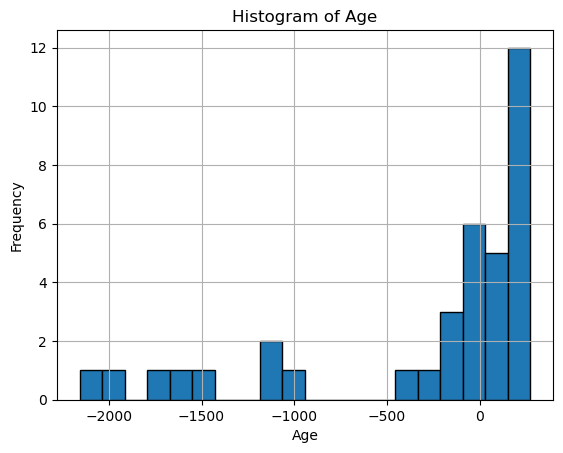

In [23]:
plt.hist(df['OSDate - dateEntry'], bins=20, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')
plt.grid(True)

# Show the histogram
plt.show()

In [25]:
df['HDMFDate - dateEntry'].describe()

count     244.000000
mean       44.913934
std       157.208666
min     -1620.000000
25%        43.000000
50%        63.000000
75%        91.000000
max       313.000000
Name: HDMFDate - dateEntry, dtype: float64

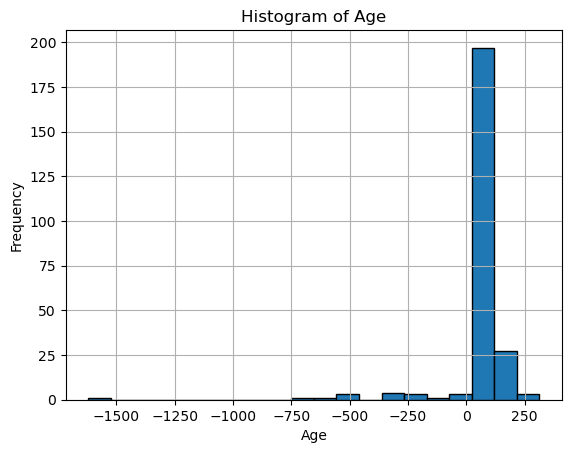

In [22]:
plt.hist(df['HDMFDate - dateEntry'], bins=20, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')
plt.grid(True)

# Show the histogram
plt.show()